testing ground for prophet stuff (for now)

In [12]:
%load_ext autoreload
%autoreload 2

In [1]:
# add all imports here
%pip install -r requirements.txt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from prophet import Prophet
from datetime import datetime


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/home/paulsera1/ucla/cs239/serverless-forecasting/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
load_azure_data()

Loading cached data...
Extracted files to: data


In [3]:
df = pd.read_csv("data/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt")
df["start_timestamp"] = df["end_timestamp"] - df["duration"]
df = df.sort_values(by="start_timestamp", ascending=True)

In [4]:
single_function_df = df.loc[df["func"] == df["func"].mode()[0]].copy()
single_function_df["end_timestamp"] = single_function_df['end_timestamp'] - single_function_df['start_timestamp'].iloc[0]
single_function_df["start_timestamp"] = single_function_df['start_timestamp'] - single_function_df['start_timestamp'].iloc[0]
single_function_df.head()

,app,func,end_timestamp,duration,start_timestamp
956,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,0.611000,0.611,0.000000
957,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.418832,0.171,1.247832
958,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.599366,0.007,1.592366
959,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,2.946063,0.006,2.940063
960,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,3.222266,0.001,3.221266


In [5]:
reference_time = pd.to_datetime(datetime.now())

BIN_SIZE = 3

bins = range(0, int(single_function_df["start_timestamp"].max()) + BIN_SIZE, BIN_SIZE)
single_function_df["time_bucket"] = pd.cut(single_function_df["start_timestamp"], bins=bins, right=False)
bucket_counts = single_function_df['time_bucket'].value_counts().sort_index()

In [6]:
train_df = bucket_counts.reset_index()
train_df["time_bucket"] = reference_time + pd.to_timedelta(train_df.index * BIN_SIZE, unit="s")
train_df = train_df.rename(columns={"time_bucket": "ds", "count": "y"}).head(5000)
train_df.head()

,ds,y
0,2025-02-20 11:12:35.439103,4
1,2025-02-20 11:12:38.439103,5
2,2025-02-20 11:12:41.439103,8
3,2025-02-20 11:12:44.439103,4
4,2025-02-20 11:12:47.439103,4


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      5000 non-null   datetime64[ns]
 1   y       5000 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 78.2 KB


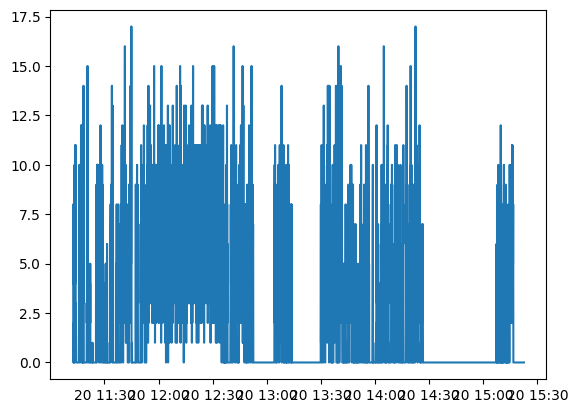

In [8]:
plt.plot(train_df["ds"], train_df["y"])

In [9]:
model = Prophet(changepoint_prior_scale=1)
model.add_seasonality(name='seconds_level', period=60, fourier_order=20)
model.add_seasonality(name="minute_level", period=3600, fourier_order=5)
model.fit(train_df)

11:12:45 - cmdstanpy - INFO - Chain [1] start processing
11:12:50 - cmdstanpy - INFO - Chain [1] done processing


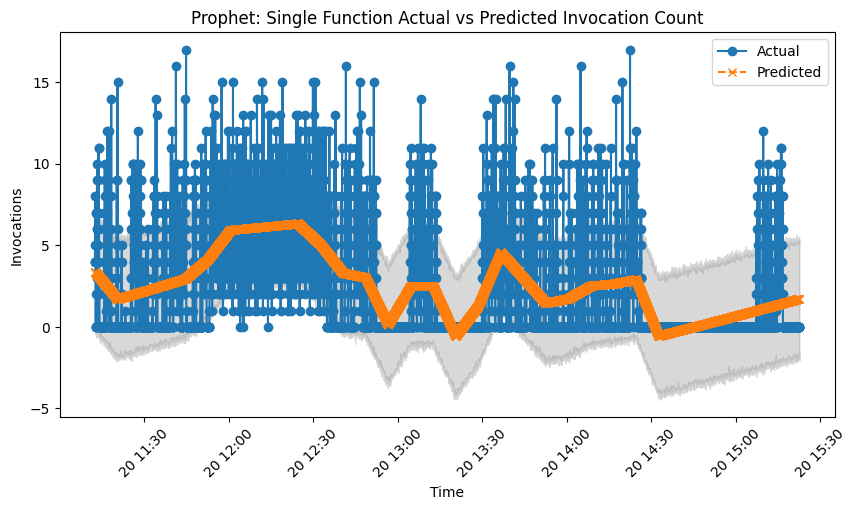

In [10]:
forecast_train = model.predict(train_df[['ds']])
df_results = train_df[['ds', 'y']].merge(forecast_train[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

plt.figure(figsize=(10, 5))
plt.plot(df_results['ds'], df_results['y'], label="Actual", marker="o", linestyle="-")
plt.plot(df_results['ds'], df_results['yhat'], label="Predicted", marker="x", linestyle="--")

plt.fill_between(df_results['ds'], df_results['yhat_lower'], df_results['yhat_upper'], color='gray', alpha=0.3)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Invocations")
plt.title("Prophet: Single Function Actual vs Predicted Invocation Count")
plt.xticks(rotation=45)
plt.show()


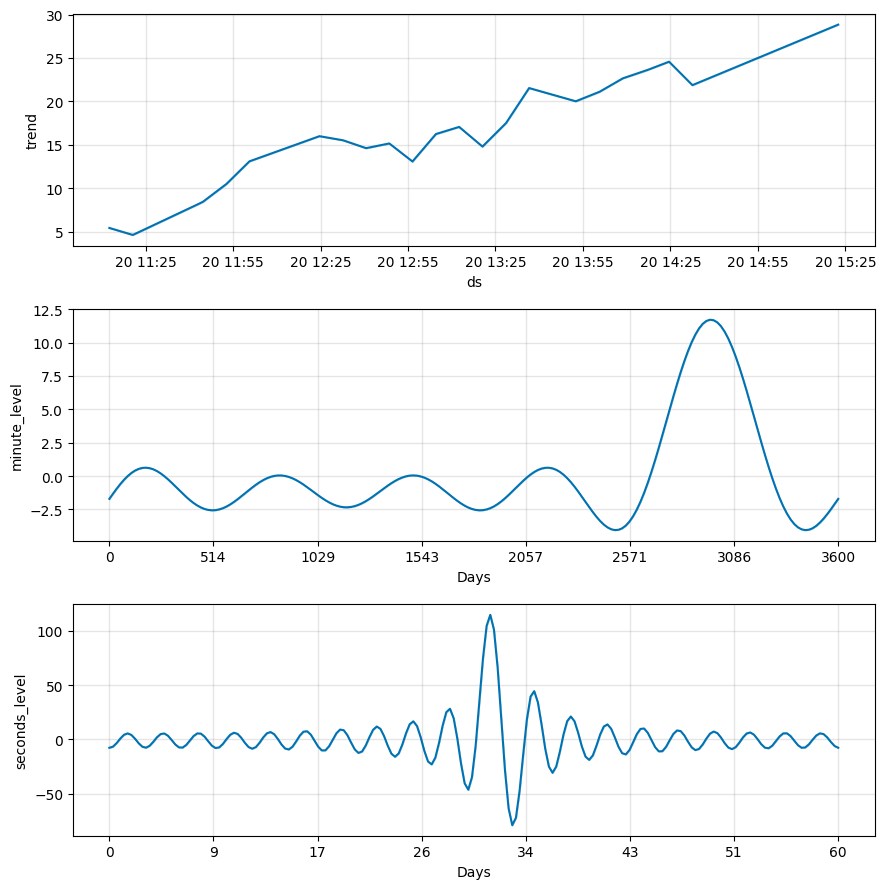

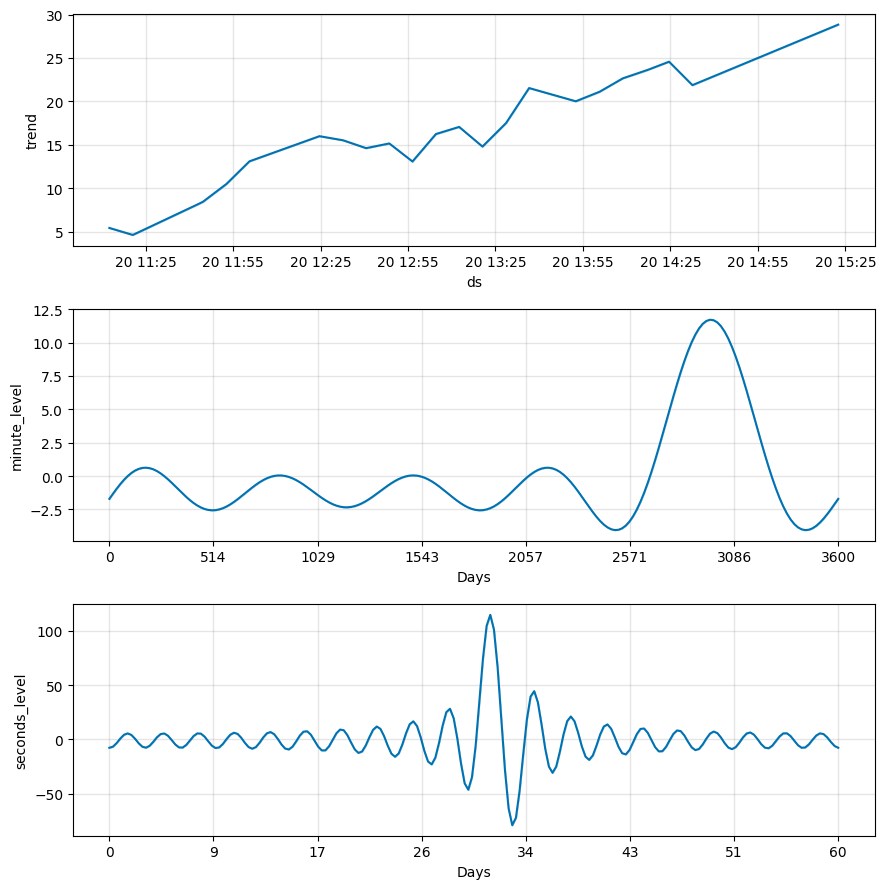

In [11]:
model.plot_components(forecast_train)